In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from GridSearchCV_func import *

C:\Users\Sam\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3.1 The Data

In [2]:
df = pd.read_csv("dataQ3.csv")
print(df.shape)
df.head(5)

(550, 2)


,Months.since.Jan.1960,temp
0,1,15.175720
1,2,14.181288
2,3,15.258313
3,4,18.085089
4,5,10.746417


In [11]:
df.describe()

,Months.since.Jan.1960,temp
count,550.000000,550.000000
mean,297.496364,12.968891
std,172.315546,6.989892
min,1.000000,-1.475230
25%,150.250000,7.671549
50%,298.500000,12.482014
75%,443.750000,17.038214
max,600.000000,34.277656


<Figure size 360x360 with 0 Axes>

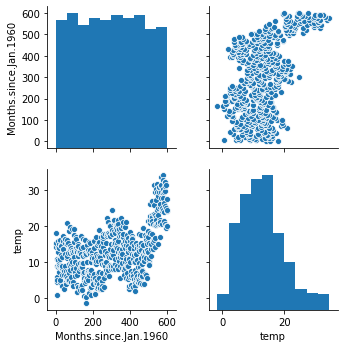

In [4]:
plt.figure(figsize=(5,5))
sns.pairplot(df)
plt.show()

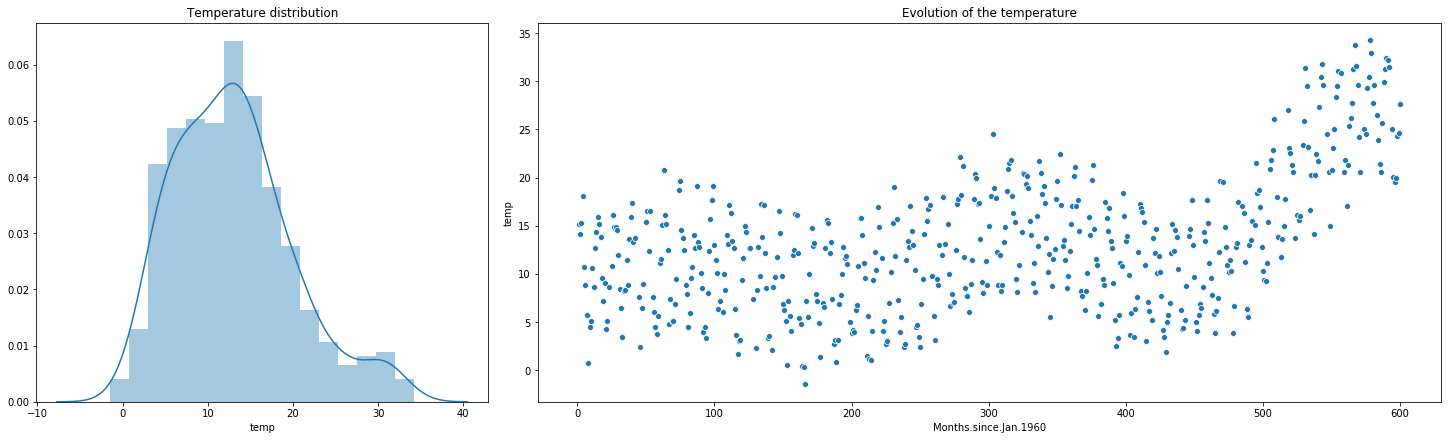

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(20,6))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])


sns.distplot(df['temp'], ax=ax1)
sns.scatterplot(x='Months.since.Jan.1960', y='temp', data=df, ax=ax2, palette=sns.color_palette("PuBuGn_d"))

ax1.set_title('Temperature distribution')
ax2.set_title("Evolution of the temperature")

plt.show()

In [3]:
df = df.rename(columns={'Months.since.Jan.1960':'m'})

In [4]:
df['year'] = (df.m -1) // 12 + 1960
df['month'] = (df['m'] -1) % 12 + 1

In [5]:
df['month_name'] = df['month'].map({1:'Jan',2:'Feb',3:"Mar",4:'Apr',5:'May',6:'Jun',
                                   7:"Jul",8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [6]:
df.head()

,m,temp,year,month,month_name
0,1,15.175720,1960,1,Jan
1,2,14.181288,1960,2,Feb
2,3,15.258313,1960,3,Mar
3,4,18.085089,1960,4,Apr
4,5,10.746417,1960,5,May


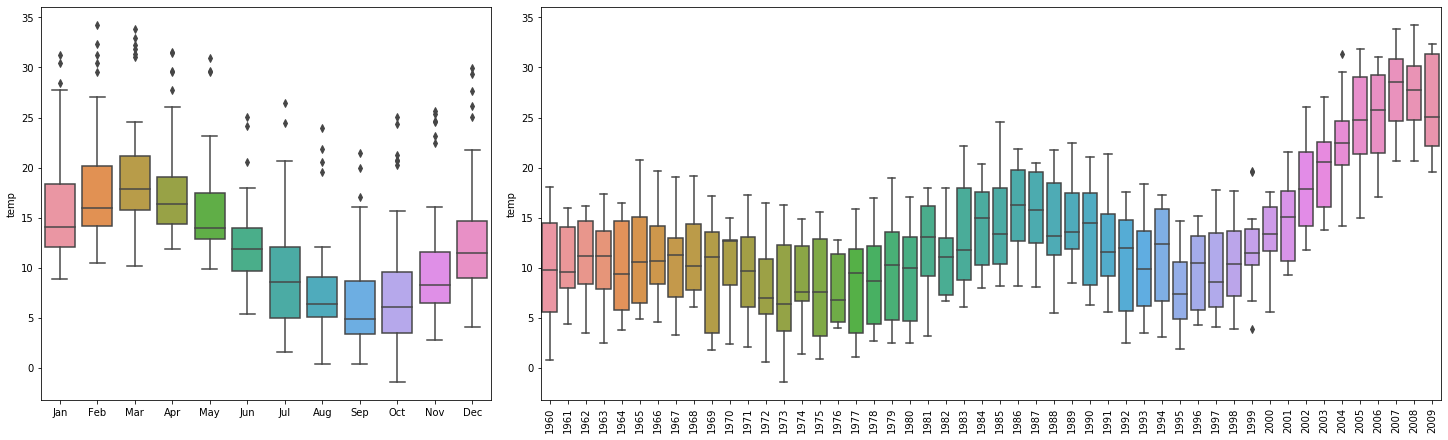

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(20,6))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

sns.boxplot(x='month_name', y='temp', data=df, ax=ax1)
sns.boxplot(x='year', y='temp', data=df, ax=ax2)

ax2.set_xticklabels(df.year.unique(), rotation=90)

ax1.set_xlabel('')
ax2.set_xlabel('')

plt.show()

In [7]:
X = df.drop(['temp'], axis=1)
y = df['temp'].values
enc = OneHotEncoder(sparse=False)
enc.fit(X['month_name'].values.reshape((-1,1)))
X_enc = enc.transform(X['month_name'].values.reshape((-1,1)))
df_enc = pd.DataFrame(data=X_enc, columns=enc.categories_[0])

X = pd.concat([X, df_enc], axis=1)

In [8]:
X.drop(['month','month_name'], axis=1).head()

,m,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1,1960,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1960,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, )

## 3.1 Bayesian Linear Model

In [14]:
sigma = 1
alpha = 1

In [13]:
class bayesian_linear_model():
    
    def __init__(self, alpha=1, sigma=1):
        self.alpha=alpha
        self.sigma=sigma
        
    def compute_Sigma_(self, X):
        return np.linalg.solve((np.dot(X.T, X) + (self.sigma**2) / self.alpha), (self.sigma**2) * np.eye(X.shape[1]))

    def compute_mu_(self, S, X, y):
        return np.dot(S, np.dot(X.T, y)) / (self.sigma**2)
    
    def fit(self, X, y):
        self.S = self.compute_Sigma_(X)
        self.mu = self.compute_mu_(self.S, X, y)

    def predict(self, X):
        return np.dot(X, self.mu)    

mse :  52.20790862513218
r2 :  0.1610809049751767


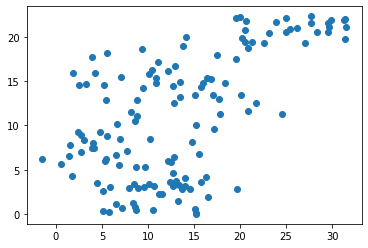

In [16]:
#model using temp and m with no preprocessing
X_train_1 = X_train['m'].values.reshape([-1,1])
X_test_1 = X_test['m'].values.reshape([-1,1])

model = bayesian_linear_model()
model.fit(X_train_1,y_train)
y_pred = model.predict(X_test_1)
print('mse : ', np.mean((y_test - y_pred)**2))
print('r2 : ', r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)

mse :  55.86375001241296
r2 :  0.10233587517148346


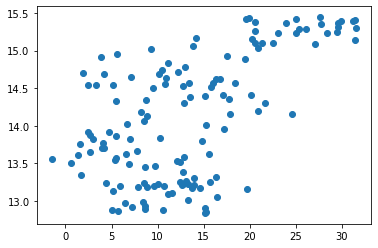

In [17]:
#model using temp and m, scaling temp
X_train_1 = X_train['m'].values.reshape([-1,1]) 
X_test_1 = X_test['m'].values.reshape([-1,1])

y_train_1 = (y_train  - np.mean(y_train)) / np.std(y_train)

model = bayesian_linear_model()
model.fit(X_train_1,y_train_1)
y_pred = model.predict(X_test_1) * np.std(y_train) + np.mean(y_train)
print('mse : ', np.mean((y_test - y_pred)**2))
print('r2 : ', r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)

mse :  22.954541321077908
r2 :  0.6311477793516032


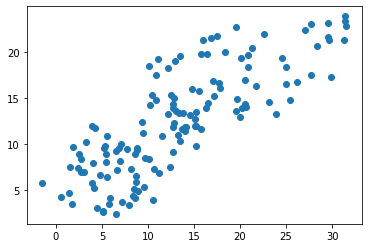

In [15]:
#model using m, year and dumb features
year_mu = np.mean(X_train.year)
year_std = np.std(X_train.year)

X_train_1 = X_train.drop(['month', 'month_name'], axis=1)

X_test_1 = X_test.drop(['month', 'month_name'], axis=1)

X_train_1 = X_train_1.values
X_test_1 = X_test_1.values

model = bayesian_linear_model()
model.fit(X_train_1,y_train)
y_pred = model.predict(X_test_1)
print('mse : ', np.mean((y_test - y_pred)**2))
print('r2 : ', r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)

In [10]:
X_train_1 = X_train.drop(['month', 'month_name'], axis=1)

X_test_1 = X_test.drop(['month', 'month_name'], axis=1)

X_train_1 = X_train_1.values
X_test_1 = X_test_1.values

In [11]:
params_grid = {'alpha' : [0.1, 0.5, 1, 2, 5, 10, 50],
              'sigma' : [0.1, 0.5, 1, 2, 5, 10, 50]}

## Gaussian Process

In [10]:
class GPRegression():
    
    def __init__(self, kernel='gaussian', amplitude=1, length=1, noise_std=1, **kwargs):
        self.amplitude = float(amplitude)
        self.length = float(length)
        self.noise_std = float(noise_std)
        if kernel == 'gaussian':
            self.kernel_func = GPRegression.gaussian_kernel(self.amplitude, self.length)
        elif kernel=='matern':
            self.kernel_func = GPRegression.matern_kernel(self.amplitude, self.length)
        elif kernel=='periodic':
            self.periodicity = float(kwargs['periodicity'])
            self.kernel_func = GPRegression.periodic_kernel(self.amplitude, self.length, self.periodicity)
        else:
            raise ValueError('kernel value shoulb be either gaussian, matern or periodic')
            
    def fit(self,X,y):
        
        self.n, self.p = X.shape
        self.X_train = X
        self.y_train = y
        self.K = np.zeros((self.n,self.n))
        for i in range(self.n):
            for j in range(self.n):
                self.K[i,j] = self.kernel_func(X[i], X[j])
                
        self.S_inv = np.linalg.solve((self.K + (self.noise_std**2)), np.eye(self.n))
        
    def predict(self, X):
        """return expected predictive posterior"""
        n_test = len(X)
        y_mean_pred = np.zeros(n_test)
        for i in range(n_test):
            Kxnew_X = self.kernel_new_vector(X[i])
            y_mean_pred[i] = np.dot(Kxnew_X.T, np.dot(self.S_inv, self.y_train))
            
        return y_mean_pred
        
        
    def kernel_new_vector(self, x_new):
        """Compute k(., X)"""
        
        Kxnew_X = np.zeros(self.n)
        for i in range(self.n):
            Kxnew_X[i] = self.kernel_func(x_new, self.X_train[i])
        
        return Kxnew_X
        
    @staticmethod
    def gaussian_kernel(amplitude, length):
        """Return a gaussian kernel function with amplitude and length"""
        
        def kernel_fun(xi, xj):
            norm_sqr = np.sum((xi - xj)**2)
            return (amplitude**2) * np.exp(- norm_sqr / (length**2))
        
        return kernel_fun
    
    @staticmethod
    def matern_kernel(amplitude, length):
        
        def kernel_fun(xi, xj):
            norm = (np.sqrt(3)/length) * np.sqrt(np.sum((xi -xj)**2))
            return (amplitude**2) * (1 + norm) * np.exp(-norm)
        
        return kernel_fun
    
    @staticmethod
    def periodic_kernel(amplitude, length, periodicity):
        
        def kernel_fun(xi, xj):
            
            sin_term = np.sin(periodicity * np.sum((xi - xj)**2) / (2 * np.pi)) ** 2
            return (amplitude**2) * np.exp(-2*sin_term / (length**2))
        
        return kernel_fun

In [11]:
X_train_1 = X_train.drop(['month', 'month_name'], axis=1)
X_test_1 = X_test.drop(['month', 'month_name'], axis=1)
X_train_1 = X_train_1.values
X_test_1 = X_test_1.values

y_train_1 = (y_train  - np.mean(y_train))/np.std(y_train)
y_test_1 = (y_test - np.mean(y_train)) / np.std(y_train)

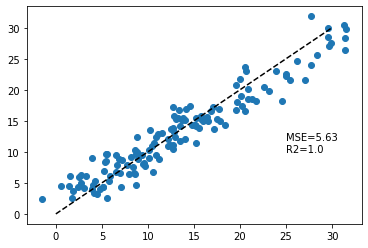

In [108]:
gp_gauss = GPRegression(kernel='gaussian', amplitude=1, length=5, noise_std=1)
gp_gauss.fit(X_train_1, y_train_1)
y_pred_gauss = gp_gauss.predict(X_test_1)*np.std(y_train) + np.mean(y_train)
mse_gauss = np.mean((y_test - y_pred_gauss)**2)
r2_gauss = r2_score(y_test, y_pred_gauss)
plt.scatter(y_test, y_pred_gauss)
plt.plot([0,30],[0,30], color='black', linestyle='--')
plt.text(25,10,'MSE={}'.format(round(mse_gauss,2)) +'\n'+ 'R2={}'.format(round(r2_gauss)))
plt.show()

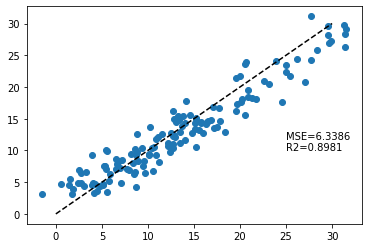

In [31]:
gp_matern = GPRegression(kernel='matern', amplitude=1, length=10, noise_std=1)
gp_matern.fit(X_train_1, y_train_1)
y_pred_matern = gp_matern.predict(X_test_1)*np.std(y_train) + np.mean(y_train)
mse_matern = np.mean((y_test - y_pred_matern)**2)
r2_matern = r2_score(y_test, y_pred_matern)
plt.scatter(y_test, y_pred_matern)
plt.plot([0,30],[0,30], color='black', linestyle='--')
plt.text(25,10,'MSE={}'.format(round(mse_matern,4)) +'\n'+ 'R2={}'.format(round(r2_matern,4)))
plt.show()

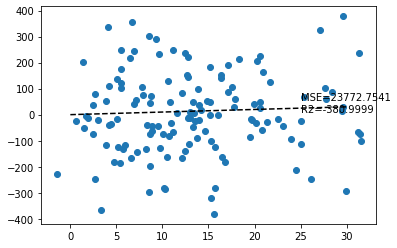

In [42]:
gp_periodic = GPRegression(kernel='periodic', amplitude=1, length=10, noise_std=1, periodicity=1)
gp_periodic.fit(X_train_1, y_train_1)
y_pred_periodic = gp_periodic.predict(X_test_1)*np.std(y_train) + np.mean(y_train)
mse_periodic = np.mean((y_test - y_pred_periodic)**2)
r2_periodic = r2_score(y_test, y_pred_periodic)
plt.scatter(y_test, y_pred_periodic)
plt.plot([0,30],[0,30], color='black', linestyle='--')
plt.text(25,10,'MSE={}'.format(round(mse_periodic,4)) +'\n'+ 'R2={}'.format(round(r2_periodic,4)))
plt.show()

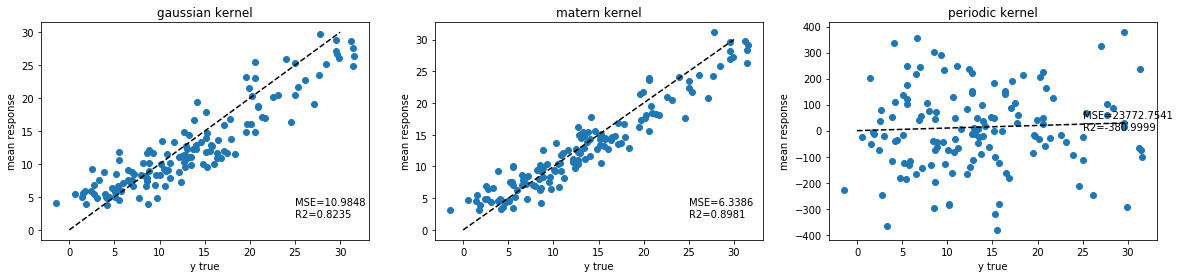

In [46]:
y_pred_dict = {'gaussian':y_pred_gauss, 'matern':y_pred_matern,'periodic':y_pred_periodic}

f, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

for i, d in enumerate(y_pred_dict.items()):
    kernel_name, y_pred = d
    mse = np.mean((y_test - y_pred)**2)
    r2 = r2_score(y_test, y_pred)
    ax = axes[i]
    ax.scatter(y_test, y_pred)
    ax.plot([0,30],[0,30], color='black', linestyle='--')
    ax.text(25,2,'MSE={}'.format(round(mse,4)) +'\n'+ 'R2={}'.format(round(r2,4)))
    ax.set_title(kernel_name + ' kernel')
    ax.set_xlabel('y true')
    ax.set_ylabel('mean response')
    
plt.show()


## Cross Validation

In [18]:
params_dict = {'kernel':['gaussian', 'matern', "periodic"],
               "amplitude" : [0.1, 1, 5, 10, 40],
              "length" : [0.1, 1, 10, 20],
              "periodicity" : [0.1, 1, 50, 100]}

In [12]:
best_params = {'kernel': 'matern', 'amplitude': 5.0, 'length': 10.0}

In [13]:
best_gp_regression = GPRegression(**best_params)
best_gp_regression.fit(X_train_1, y_train_1)

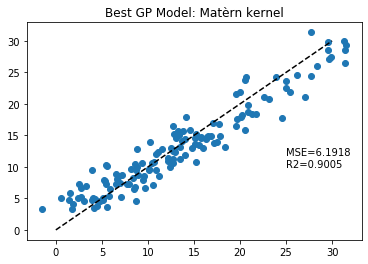

In [15]:
y_pred_matern = best_gp_regression.predict(X_test_1)*np.std(y_train) + np.mean(y_train)
mse_matern = np.mean((y_test - y_pred_matern)**2)
r2_matern = r2_score(y_test, y_pred_matern)
plt.scatter(y_test, y_pred_matern)
plt.plot([0,30],[0,30], color='black', linestyle='--')
plt.text(25,10,'MSE={}'.format(round(mse_matern,4)) +'\n'+ 'R2={}'.format(round(r2_matern,4)))
plt.title('Best GP Model: Matèrn kernel')
plt.show()